In [1]:
import os
import pandas as pd
import numpy as np
from utils import (
    coverage_dowmonth,
    coverage_mthyr,
    save_mpl_fig,
    its, 
    plotline, 
    plot_dual_indices
)

FP = '../data/nyt_1987_2007_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 
os.makedirs('../figs/data_coverage', exist_ok=True) 

### Data coverage

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(date=lambda df: pd.to_datetime(df.date))
      .groupby(['date']).size().reset_index()
      .rename(columns={0:'obs'})
      .assign(year=lambda df: [dt64.year for dt64 in df.date])
     )
df.head(3)

,date,obs,year
0,1987-01-01,464,1987
1,1987-01-02,418,1987
2,1987-01-03,354,1987


D:\readable_news\scripts\utils.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=figsize)


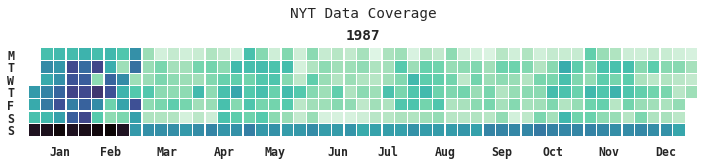

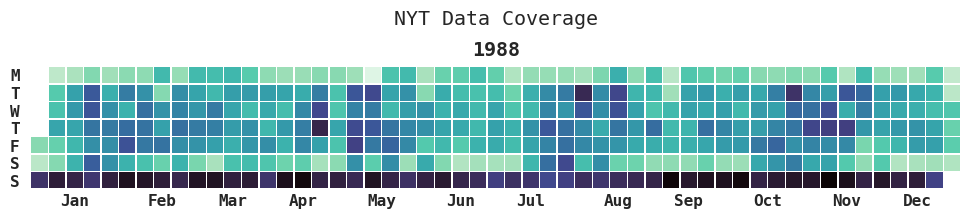

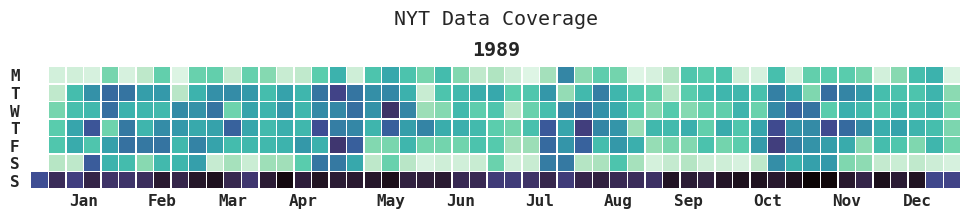

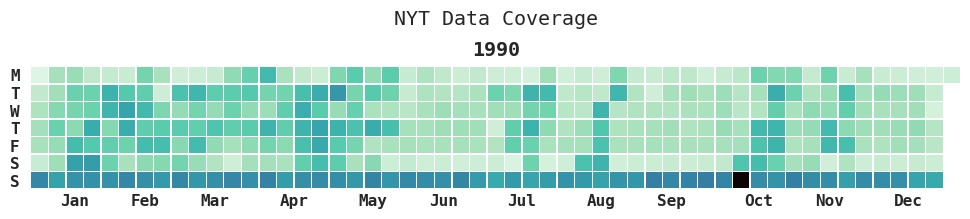

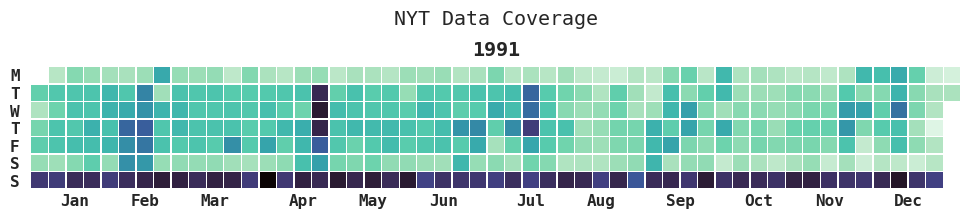

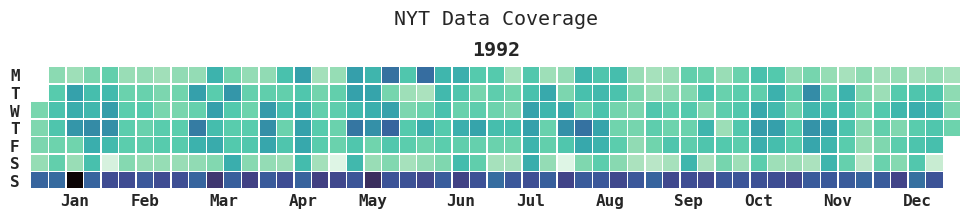

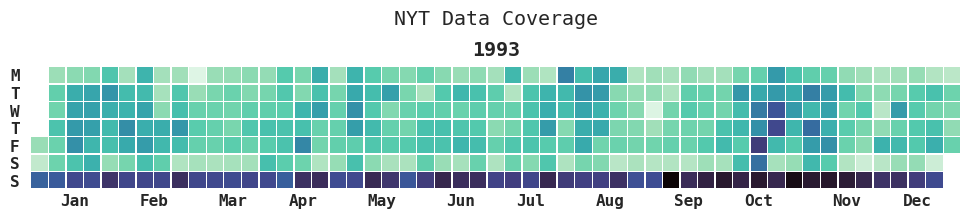

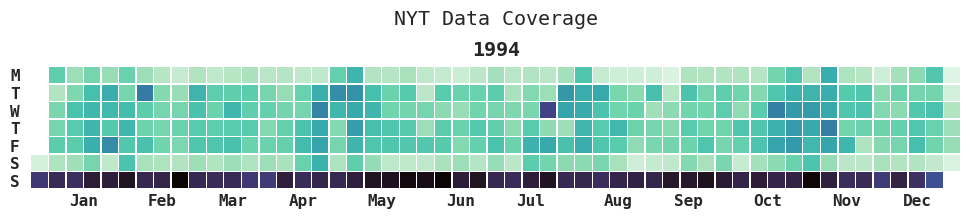

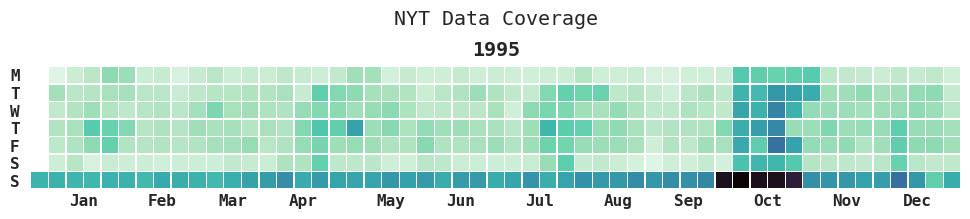

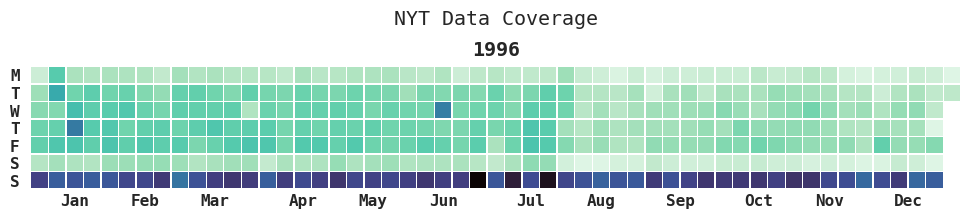

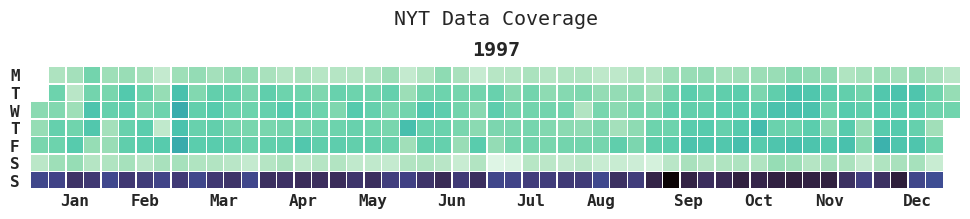

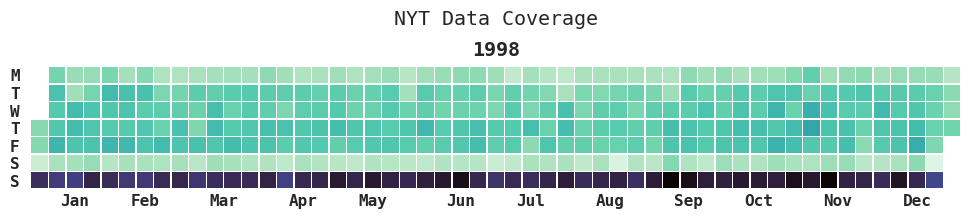

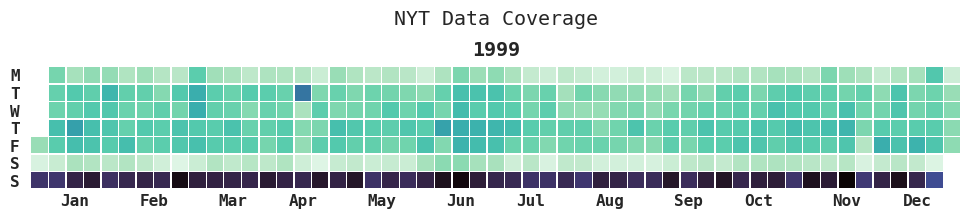

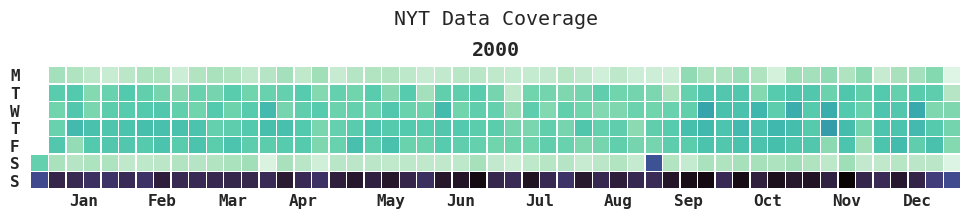

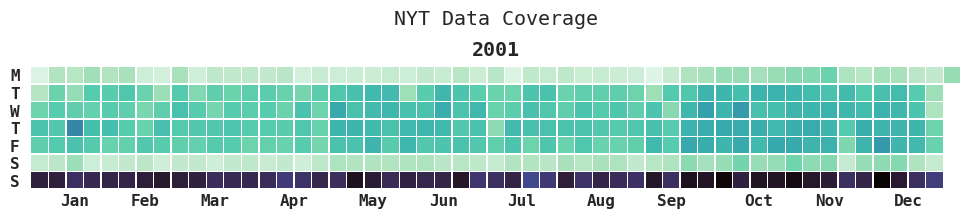

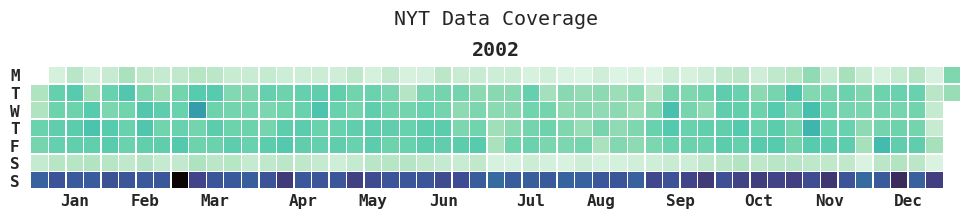

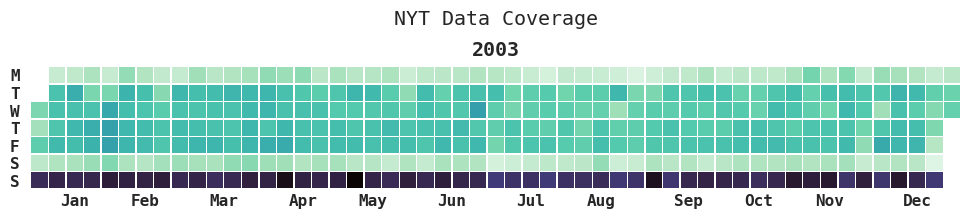

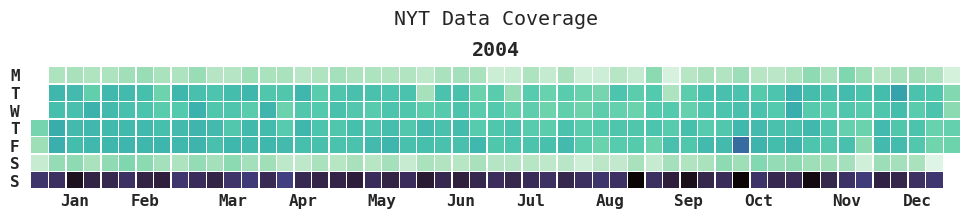

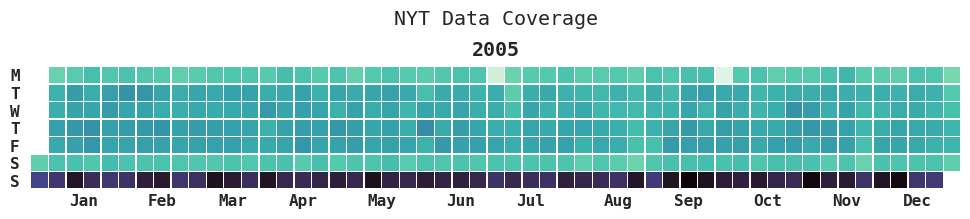

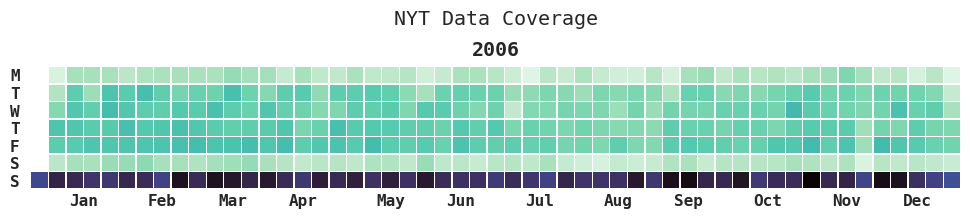

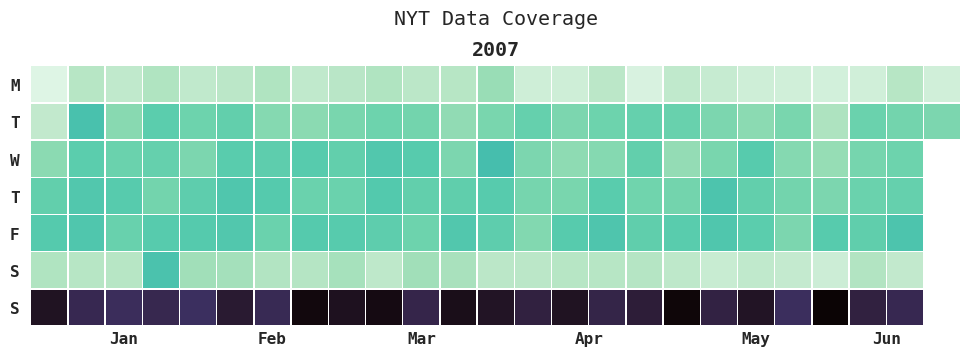

In [3]:
for year in df.year.unique():
    _df = df.query('year==@year')
    coverage_dowmonth(_df.date, _df.obs, title='NYT Data Coverage')
    save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/nyt_dowmonth_{year}'))

In [4]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(date=lambda df: pd.to_datetime(df.date))
      .set_index('date').groupby(pd.Grouper(freq='M')).size().reset_index()
      .rename(columns={0: 'count'})
      .assign(month=lambda df: [dt64.month_name()[:3] for dt64 in df.date],
              monthix=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date])
      .pivot(['month', 'monthix'], 'year', 'count')
      .sort_values('monthix').droplevel('monthix')
     )
df.head(3)

year,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
month,,,,,,,,,,,,,,,,,,,,,
Jan,18006.0,8729.0,8501.0,8703.0,6983.0,7237.0,6945.0,6415.0,6387.0,7078.0,...,7381.0,8041.0,7868.0,7706.0,8055.0,7964.0,7749.0,7707.0,7433.0,7038.0
Feb,14191.0,8646.0,8050.0,8271.0,7422.0,5695.0,6221.0,5619.0,5164.0,6600.0,...,6731.0,6924.0,7341.0,7026.0,7520.0,7373.0,7610.0,6992.0,6906.0,6570.0
Mar,8692.0,8750.0,8779.0,8674.0,7267.0,7335.0,5612.0,5960.0,6050.0,7119.0,...,7627.0,7736.0,7834.0,7549.0,8782.0,8329.0,7706.0,7656.0,7635.0,7255.0


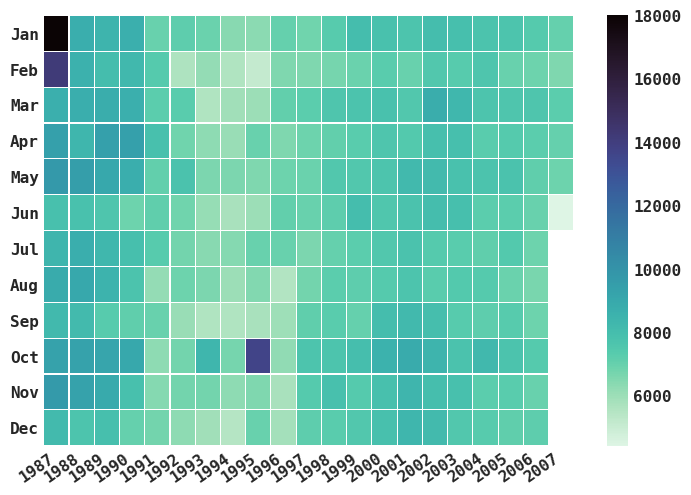

In [5]:
coverage_mthyr(df, xtickangle=35)
save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/nyt_monthyear'))

### Readability & Lexical Richness

In [6]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .rename(columns={'Publication Date': 'date'})
      .assign(date=lambda df: pd.to_datetime(df.date),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )
      # Drop outliers by length
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
      .query(f'terms>100')
      .groupby(['mthyr']).mean().reset_index()
     )
df.head(3)

,mthyr,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,year
0,1987-01-01,51.837051,12.878804,14.026156,11.993061,553.266505,241.097745,0.464928,83.235364,0.810895,1.0,1987.0
1,1987-02-01,51.113731,13.177527,14.340310,11.876475,556.443860,242.093609,0.466357,83.654978,0.810370,2.0,1987.0
2,1987-03-01,52.856384,12.410780,13.560320,12.193540,574.985288,251.298515,0.466287,85.652236,0.816618,3.0,1987.0


<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

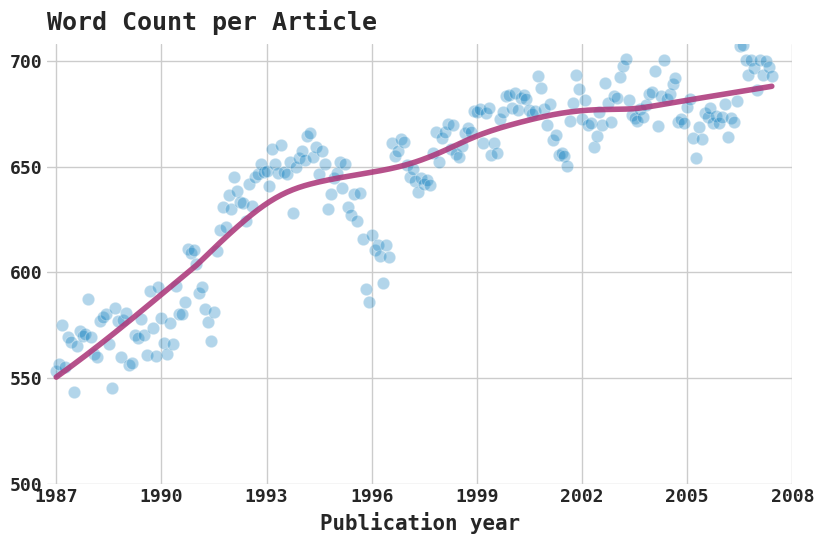

In [7]:
plotline(x=df.index, y=df.terms, yrange=range(500,750,50), title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'nyt_wordcount'))    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

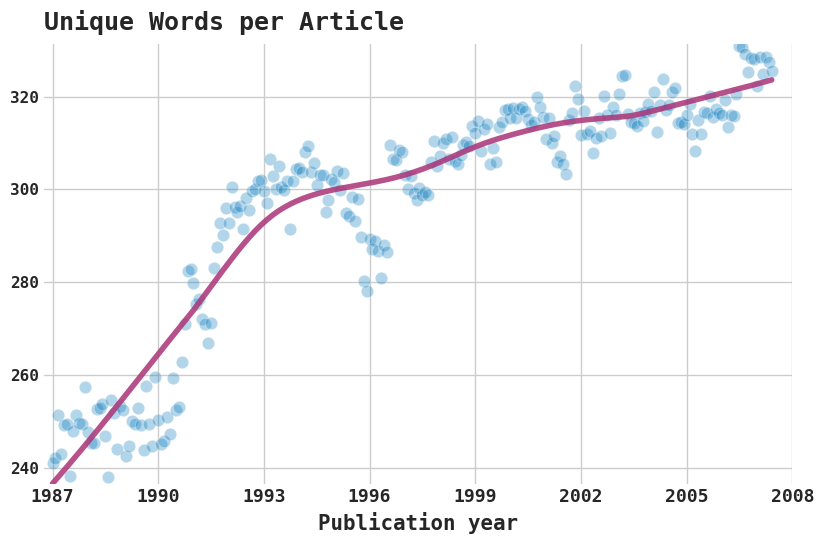

In [8]:
plotline(x=df.index, y=df.uniqueterms, title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'nyt_uniquewords'))    

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

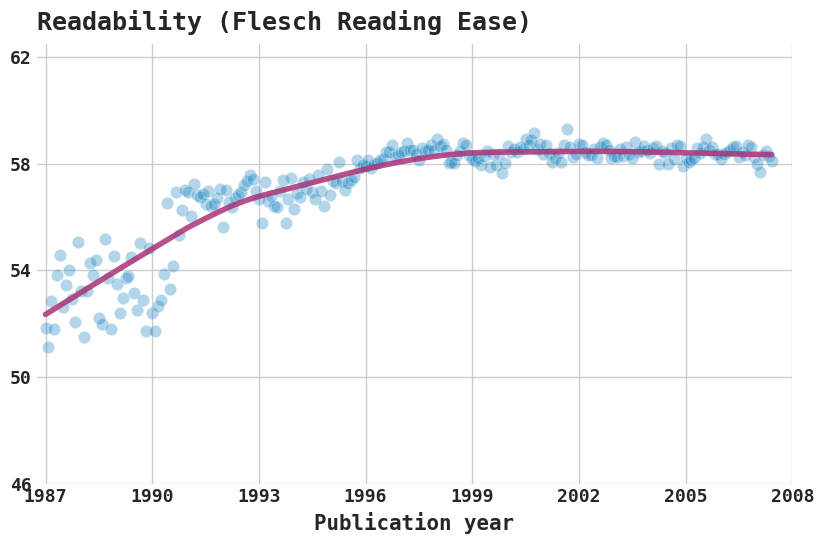

In [9]:
plotline(x=df.index, y=df.flesch_reading_ease, yrange=range(46,66,4), title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'nyt_readability_flesch_ease'))    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

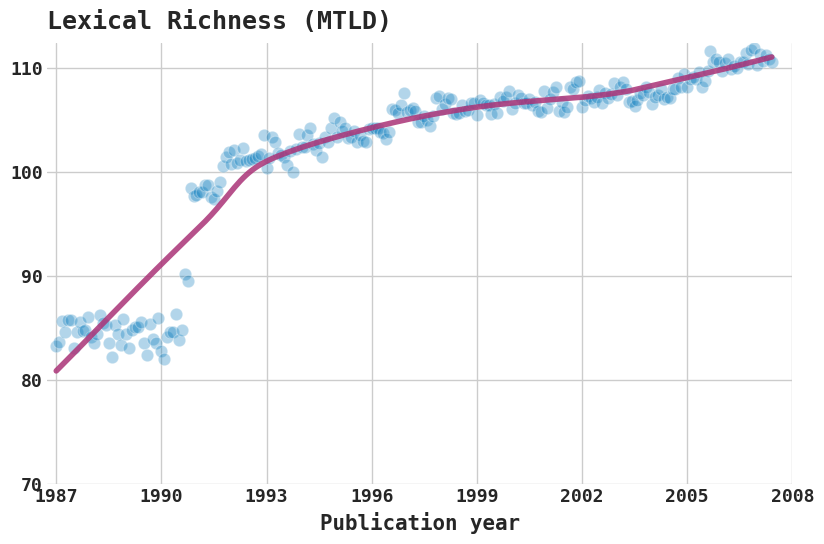

In [10]:
plotline(x=df.index, yrange=range(70,120,10), y=df.mtld, title='Lexical Richness (MTLD)', 
         savepath=os.path.join(SAVEPATH, 'nyt_lexicalrichness_mtld'))    

In [11]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
       .rename(columns={'Publication Date': 'date'})
       .assign(date=lambda df: pd.to_datetime(df.date),
               month=lambda df: [dt64.month for dt64 in df.date],
               year=lambda df: [dt64.year for dt64 in df.date],
               mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
              )
       # Drop outliers by length
       .pipe(lambda df: 
             df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
       .query(f'terms>100')
       .groupby(['year']).mean().reset_index()
       .assign(
           iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
           ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
           imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
           ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
           iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
           iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
       )
     )
idf.head(3)

,year,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,1987,52.821059,12.500089,13.650798,12.064077,564.122260,246.784134,0.466880,84.613119,0.814336,5.877398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1988,53.313572,12.324969,13.474752,12.066032,569.505123,248.816365,0.466661,84.427760,0.815124,6.506386,0.932419,0.016203,-0.219066,-0.046795,0.954202,0.823485
2,1989,53.404118,12.270222,13.412850,12.122565,571.538937,249.669473,0.467088,84.387931,0.815093,6.521778,1.103840,0.484815,-0.266138,0.044644,1.314729,1.169175


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change from 1987'>

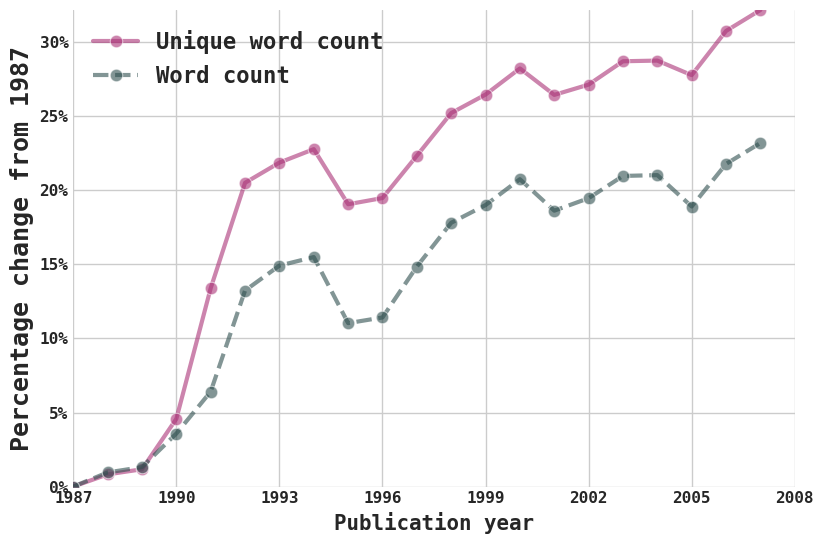

In [12]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, xrange=range(1987, 2010, 3),
                  label1='Unique word count', label2='Word count', title='',
                  savepath=os.path.join(SAVEPATH, 'nyt_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

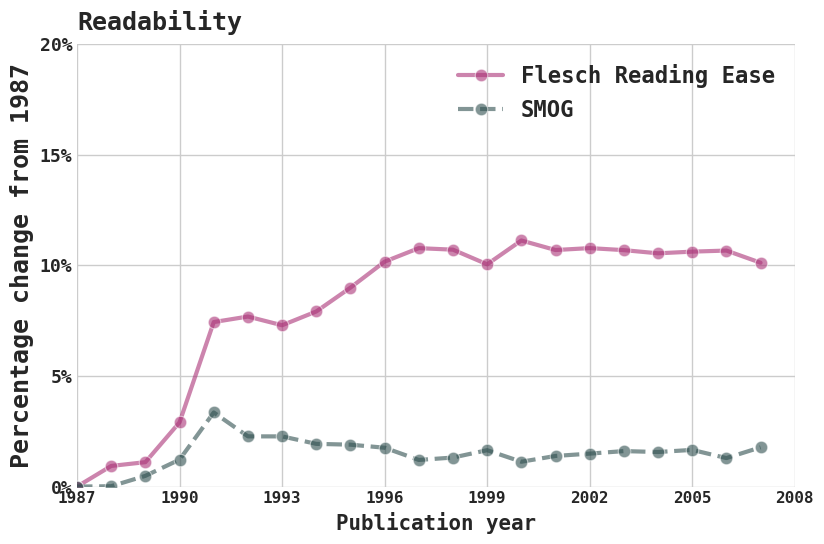

In [13]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog,
                  yrange=range(0,25,5), xrange=range(1987, 2010, 3), 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  savepath=os.path.join(SAVEPATH, 'nyt_readability_index'))    

<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change from 1987'>

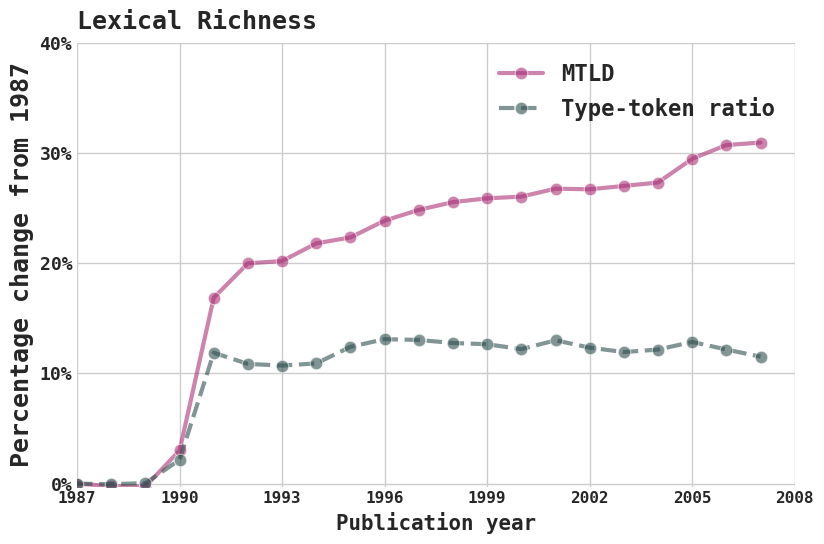

In [14]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, 
                  yrange=range(0,50,10), xrange=range(1987, 2010, 3), 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  savepath=os.path.join(SAVEPATH, 'nyt_lexicalrichness_index'))    